In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from wordcloud import WordCloud
%matplotlib inline

In [7]:
def cm_plot(cm, y_test, title):
    N = list(map(lambda clazz : sum(y_test == clazz), [*range(1,6)]))
    plt.figure(figsize=(7,5)) 
    c = plt.pcolormesh([cm[j, :] / N[j] for j in range(5)], vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks(0.5 + np.arange(5), np.arange(1,6))
    plt.yticks(0.5 + np.arange(5), np.arange(1,6))
    c.update_scalarmappable()
    ax = c.axes
    for p, color, value in zip(c.get_paths(), c.get_facecolors(), c.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        ax.text(x, y, "%.2f" % value, ha="center", va="center", color=(0.0, 0.0, 0.0) if sum(color[:2] > 0.3) >= 2 else (1.0, 1.0, 1.0))
#     plt.savefig(title+'.png', bbox_inches='tight', dpi=300)
    return plt.show()

def wc_plot(d, title):
    wordcloud = WordCloud(width=3423, height=1821, mode="RGBA", background_color=None)
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure(figsize=(14,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
#     plt.savefig(title+'.png', bbox_inches='tight', dpi=300)
    return plt.show()

In [9]:
df = pd.read_csv('../raw.nosync/reviewSample.csv', sep='\t')
X_train, X_test, y_train, y_test = train_test_split(df.text.values, df.stars, test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(stop_words = 'english', max_features=5000)
V_train = vectorizer.fit_transform(X_train).toarray()
words = vectorizer.get_feature_names()
V_test = vectorizer.transform(X_test).toarray()

In [ ]:
classifiers = {'Naive Bayes': MultinomialNB(), 
               'Logistic Regression': LogisticRegression(), 
               'Random Forest': RandomForestClassifier(n_estimators = 10, min_samples_leaf = 20, n_jobs = -1)}
for name, clf in classifiers.items():
    clf.fit(V_train, y_train)
    if name == 'Logistic Regression':
        wc_plot({words[i]: clf.coef_[0][i] for i in np.argsort(clf.coef_[0])[::-1][:20]}, name + ' Worst Words')
        wc_plot({words[i]: clf.coef_[0][i] for i in np.argsort(clf.coef_[0])[:20]}, name + ' Best Words')
    elif name == 'Random Forest':
        wc_plot({words[i]: clf.feature_importances_[i] for i in np.argsort(clf.feature_importances_)[::-1][:30]}, name + ' Top Words')
    cm_plot(confusion_matrix(y_test, clf.predict(V_test)), y_test, name + ' Confusion Matrix')

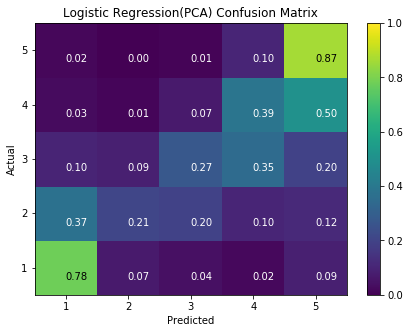

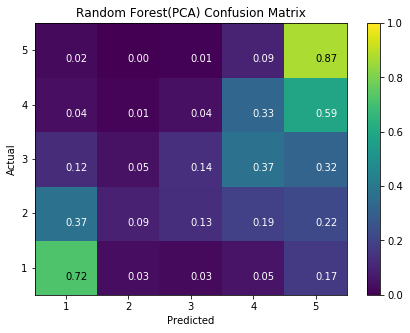

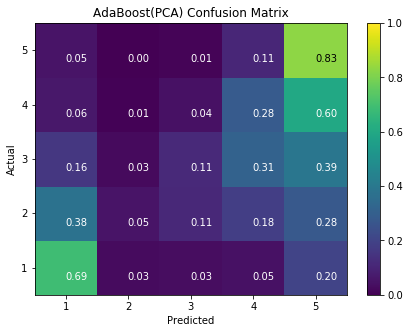

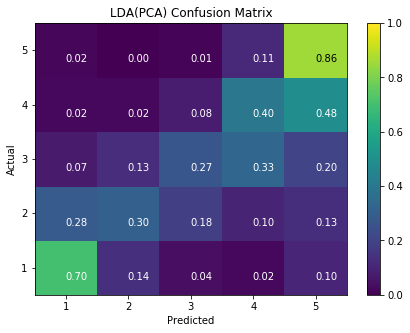

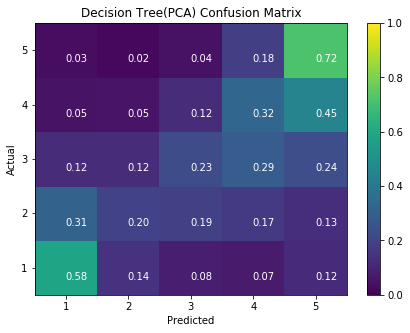

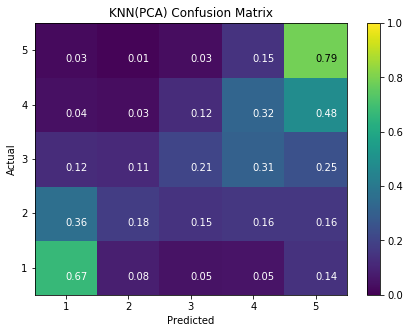

In [10]:
# plt.figure(figsize=(10,6)) 
# plt.plot(PCA(n_components = 100).fit(StandardScaler().fit_transform(V_train)).explained_variance_ratio_)
# plt.title("Scree Plot")
# plt.savefig("ScreePlot.png", dpi=300, bbox_inches='tight')
# plt.show()

scaler = StandardScaler()
pca = PCA(n_components = 50)
V_train_pca = pca.fit_transform(scaler.fit_transform(V_train))
V_test_pca = pca.transform(scaler.transform(V_test))
classifiers_pca = {'Logistic Regression(PCA)': LogisticRegression(), 
                   'Random Forest(PCA)': RandomForestClassifier(n_estimators = 10, min_samples_leaf = 20, n_jobs = -1),
                   'AdaBoost(PCA)': AdaBoostClassifier(n_estimators = 10),
                   'LDA(PCA)': LinearDiscriminantAnalysis(),
                   'Decision Tree(PCA)': DecisionTreeClassifier(max_depth = 15),
                   'KNN(PCA)': KNeighborsClassifier(p = 1, n_jobs = -1)}
for name, clf in classifiers_pca.items():
    clf.fit(V_train_pca, y_train)
    cm_plot(confusion_matrix(y_test, clf.predict(V_test_pca)), y_test, name + ' Confusion Matrix')